# IF3170 Artificial Intelligence | Praktikum

This notebook serves as a template for the assignment. Please create a copy of this notebook to complete your work. You can add more code blocks, markdown blocks, or new sections if needed.


Group Number: 19

Group Members:
- Shafiq Irvansyah (13522003)
- Raden Rafly Hanggaraksa Budiarto (13522014)

## Import Libraries

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, pointbiserialr, chi2_contingency

# Import other libraries if needed
print("Library successfully imported")

Library successfully imported


## Import Dataset

In [185]:
# Write your code here
df_test = pd.read_csv('test.csv');
df = pd.read_csv('train.csv');
df_test.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,15000,1525.0,Placebo,20392.0,F,N,Y,N,N,3.5,373.0,3.43,281.0,1523.0,188.34,193.0,227.0,12.3,2.0
1,15001,111.0,NaN,23011.0,F,NaN,NaN,NaN,N,0.6,NaN,3.69,NaN,NaN,NaN,NaN,280.0,10.8,2.0
2,15002,2149.0,NaN,23376.0,F,NaN,NaN,NaN,N,0.6,NaN,3.50,NaN,NaN,NaN,NaN,425.0,10.3,3.0
3,15003,2249.0,NaN,15706.0,F,NaN,NaN,NaN,N,0.6,NaN,3.76,NaN,NaN,NaN,NaN,225.0,10.5,4.0
4,15004,3231.0,NaN,18263.0,F,NaN,NaN,NaN,N,0.8,NaN,3.14,NaN,NaN,NaN,NaN,173.0,10.8,3.0


# 1. Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a crucial step in the data analysis process that involves examining and visualizing data sets to uncover patterns, trends, anomalies, and insights. It is the first step before applying more advanced statistical and machine learning techniques. EDA helps you to gain a deep understanding of the data you are working with, allowing you to make informed decisions and formulate hypotheses for further analysis.

## Data Understanding

In [186]:
instance, features = df.shape
print(f"Number of instances: {instance}")
print(f"Number of features: {features}")

Number of instances: 15000
Number of features: 20


In [187]:
df.dtypes

id                 int64
N_Days           float64
Drug              object
Age              float64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
Status            object
dtype: object

In [188]:
# Unique values of categorial feature
categorical_features = ["Status", "Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
for feature in categorical_features:
    print("Feature: " + feature)
    print(df[feature].unique())

Feature: Status
['D' 'C' 'CL']
Feature: Drug
['D-penicillamine' 'Placebo' nan]
Feature: Sex
['F' 'M']
Feature: Ascites
['Y' 'N' nan]
Feature: Hepatomegaly
['Y' nan 'N' '158.0']
Feature: Spiders
['N' nan 'Y']
Feature: Edema
['Y' 'N' 'S']
Feature: Stage
[4. 2. 3. 1.]


In [189]:
# The minimum, maximum, mean, median, and standard deviation values for non-categorical features.
df_des = df.drop(columns=['id'])
df_des.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,15000.000000,15000.000000,15000.000000,6626.000000,15000.000000,8340.000000,8444.000000,8441.000000,6575.000000,14416.000000,14984.000000,15000.000000
mean,1969.116920,19298.427133,1.862907,322.805916,3.520585,76.395725,1676.897656,108.214094,110.670418,254.266294,10.624837,3.014733
std,1374.093322,3706.122475,2.763713,163.041117,0.373807,76.662546,1882.904216,152.099011,49.828478,96.081587,0.729726,0.887113
min,10.800000,174.000000,0.300000,120.000000,1.960000,0.900000,3.410000,0.900000,11.000000,0.900000,4.160000,1.000000
25%,1092.000000,16463.000000,0.700000,242.000000,3.290000,31.000000,721.000000,71.000000,80.000000,189.000000,10.100000,2.000000
50%,1783.000000,19577.000000,0.900000,280.000000,3.580000,52.000000,1072.000000,97.650000,99.000000,251.000000,10.600000,3.000000
75%,2615.000000,22388.000000,1.800000,360.000000,3.770000,89.000000,1689.000000,130.200000,133.000000,312.000000,11.000000,4.000000
max,25976.000000,91894.000000,28.000000,1790.000000,4.700000,604.000000,18102.000000,12285.000000,608.000000,3150.000000,18.000000,4.000000


In [190]:
# Missing values for each feature
print(df.isnull().sum())

id                  0
N_Days              0
Drug             6550
Age                 0
Sex                 0
Ascites          6547
Hepatomegaly     6552
Spiders          6559
Edema               0
Bilirubin           0
Cholesterol      8374
Albumin             0
Copper           6660
Alk_Phos         6556
SGOT             6559
Tryglicerides    8425
Platelets         584
Prothrombin        16
Stage               0
Status              0
dtype: int64


In [191]:
# Outlier for number feature
numeric_df = df.select_dtypes(include='number')

Q1 = numeric_df.quantile(.25)
Q3 = numeric_df.quantile(.75)

IQR = Q3-Q1

df_no_outlier = df[~((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)]

org_instance, org_features = df.shape
cln_instance, cln_features = df_no_outlier.shape
df_no_outlier = df[~((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)]

org_instance, org_features = df.shape
cln_instance, cln_features = df_no_outlier.shape

print(f"Outlier detected: {org_instance - cln_instance}")

Outlier detected: 3448


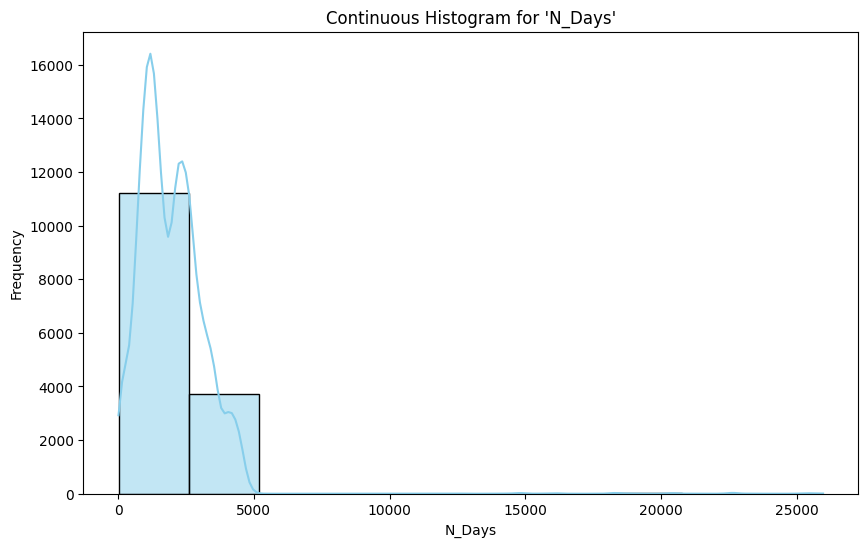

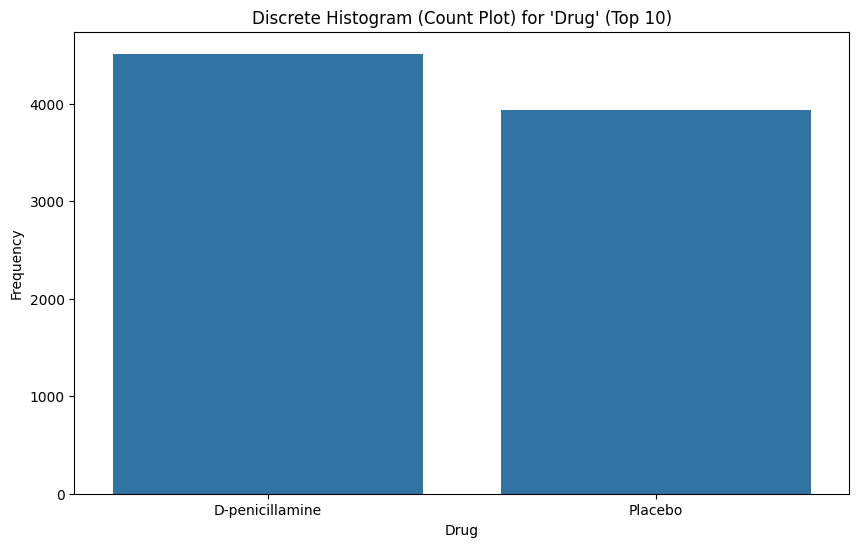

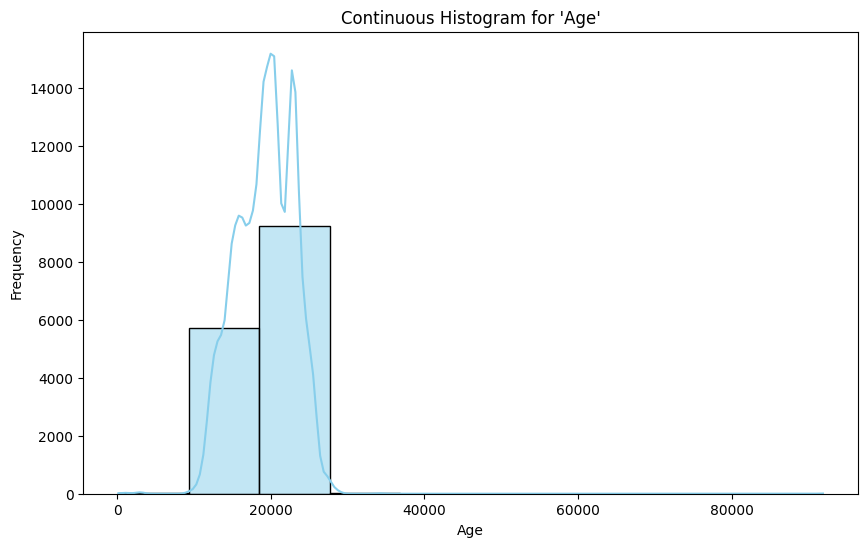

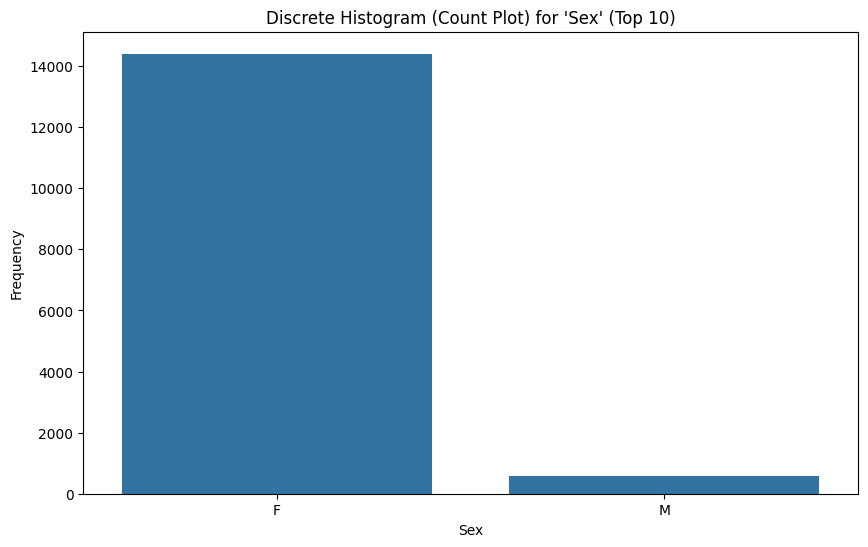

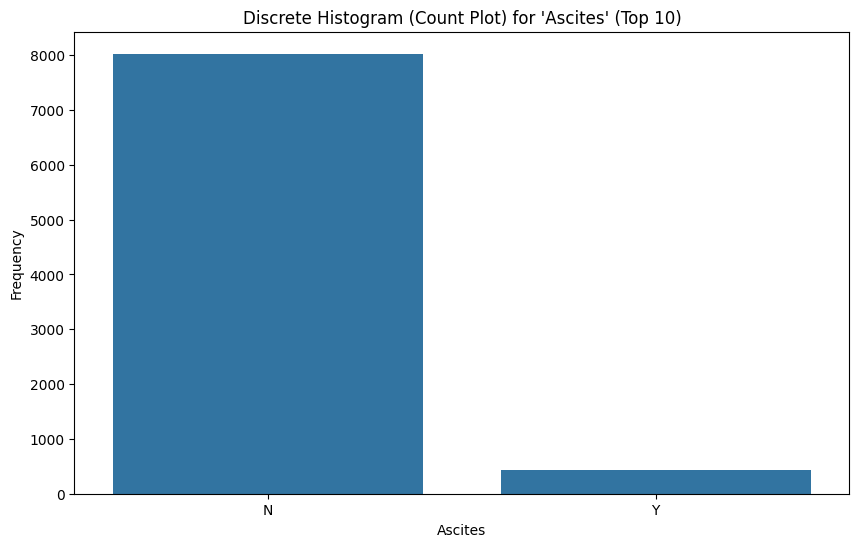

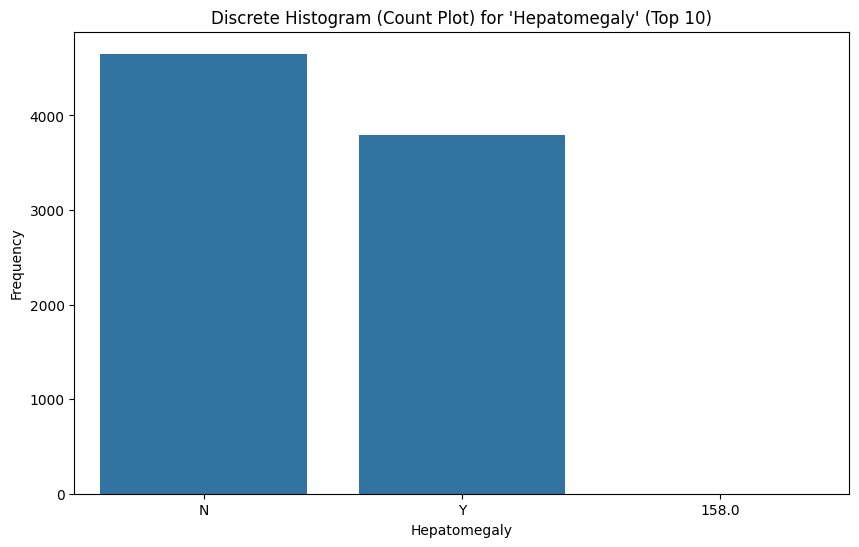

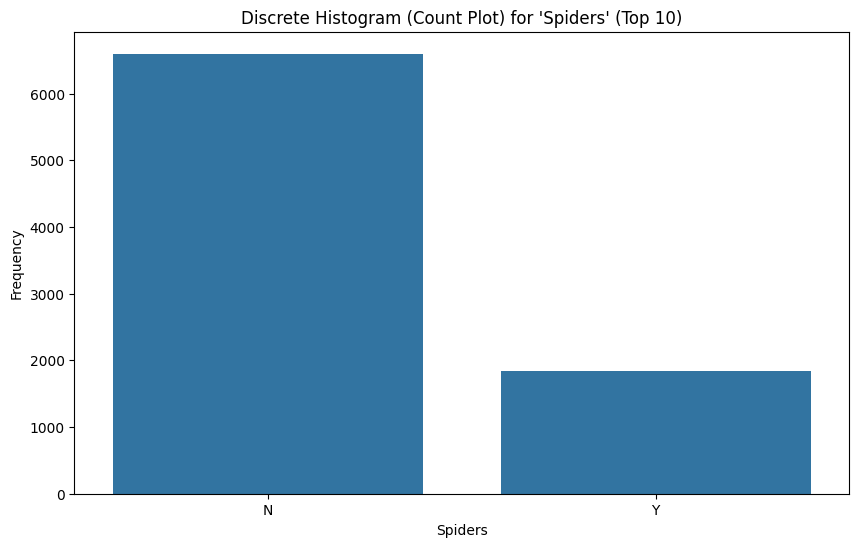

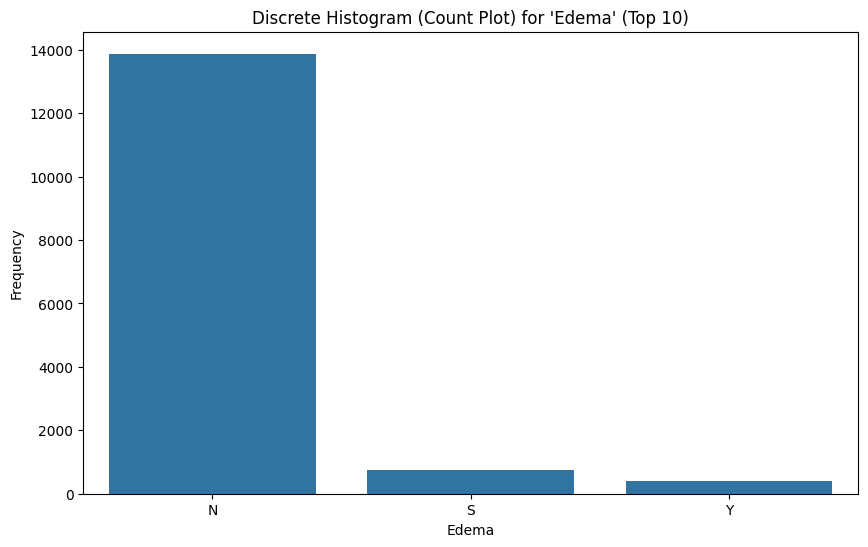

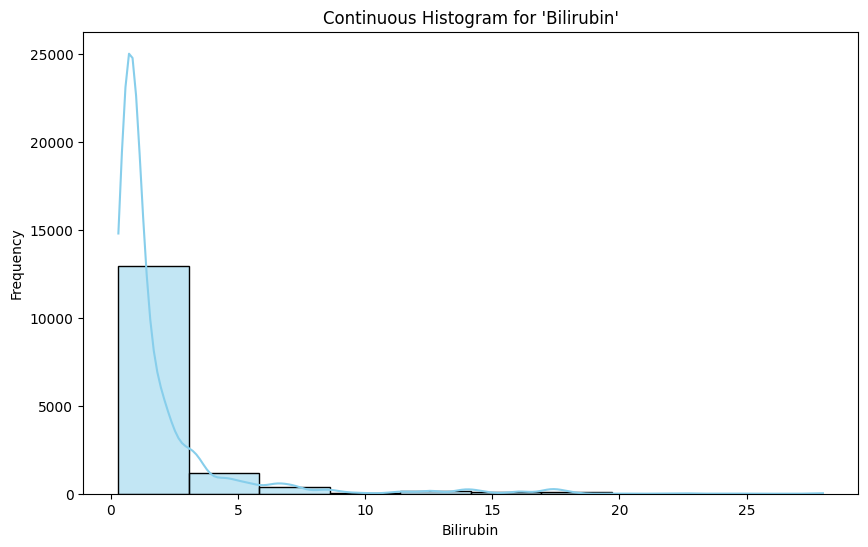

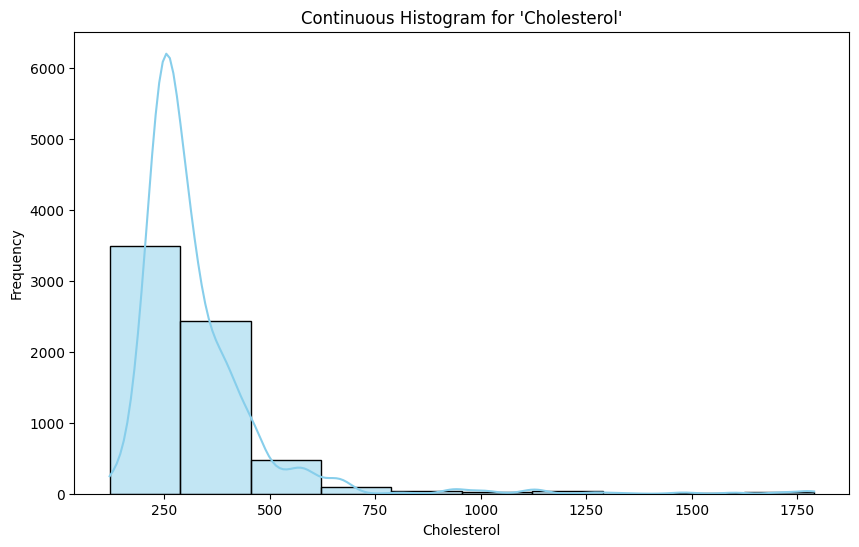

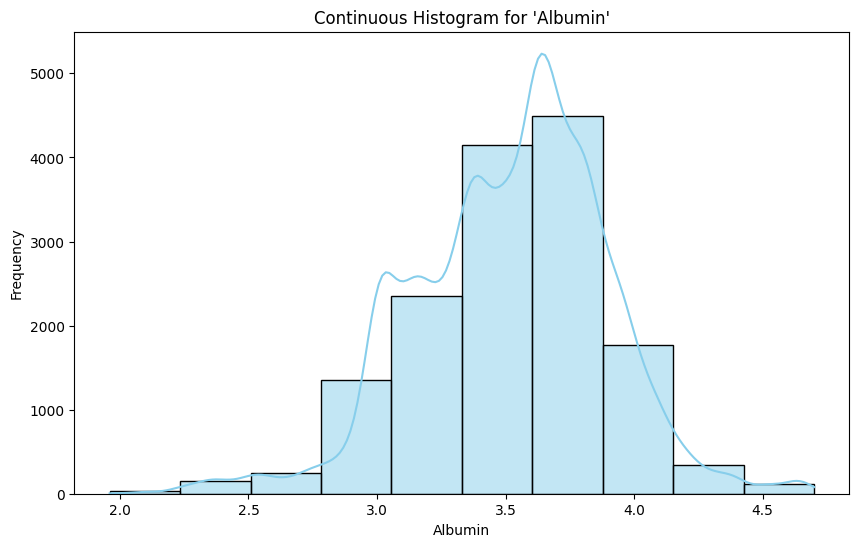

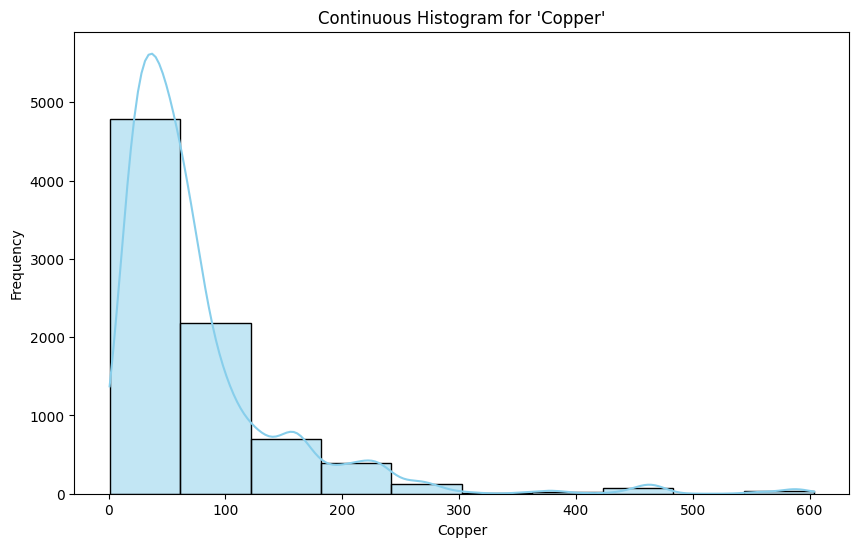

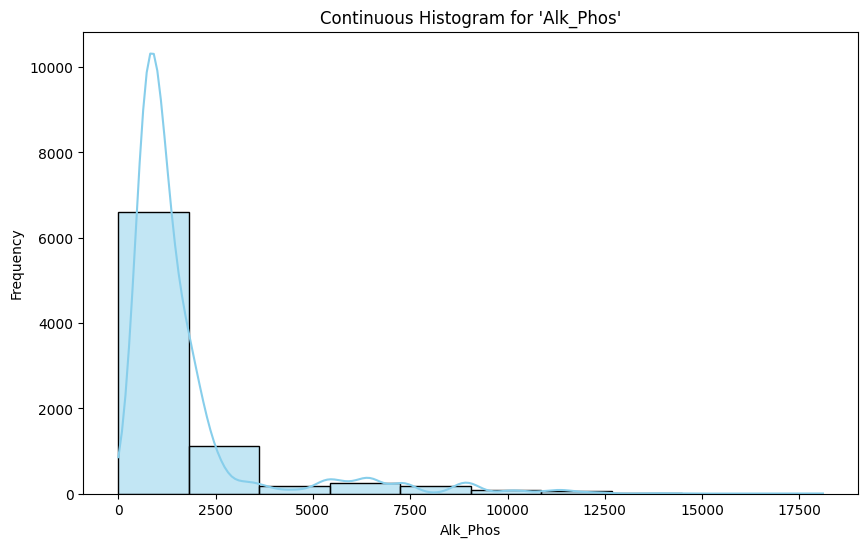

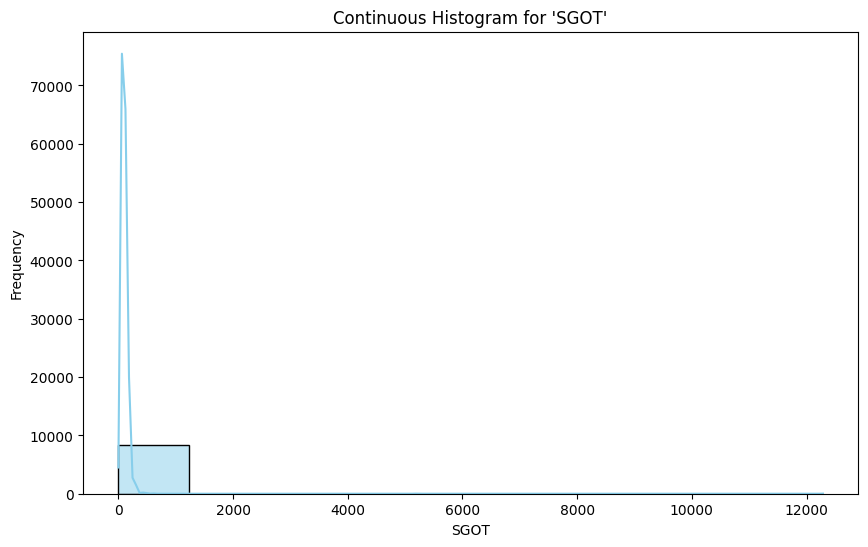

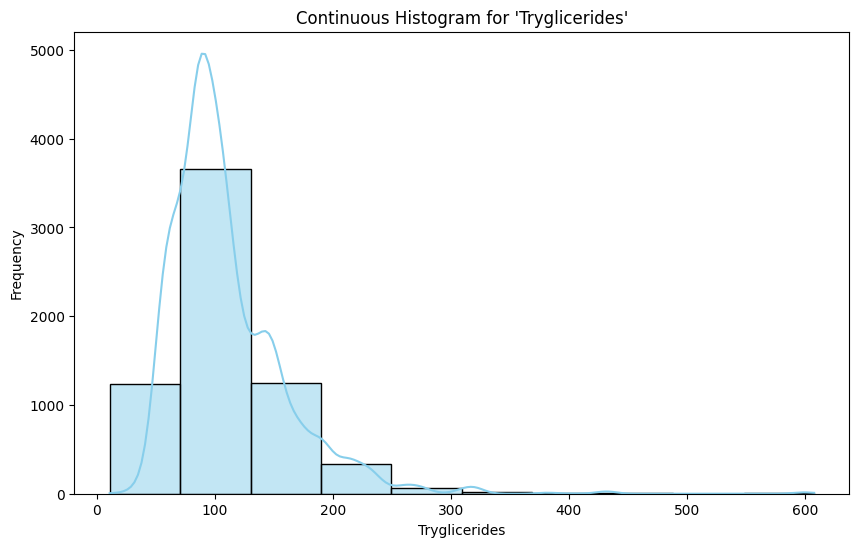

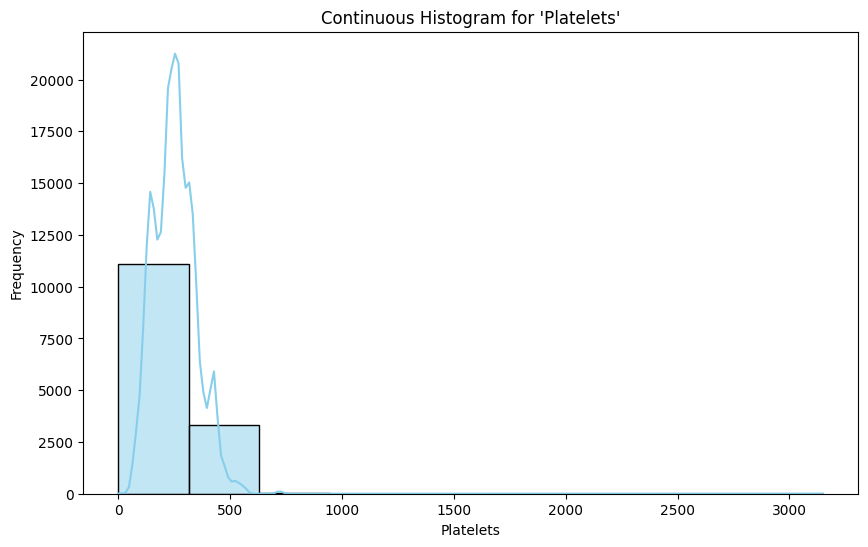

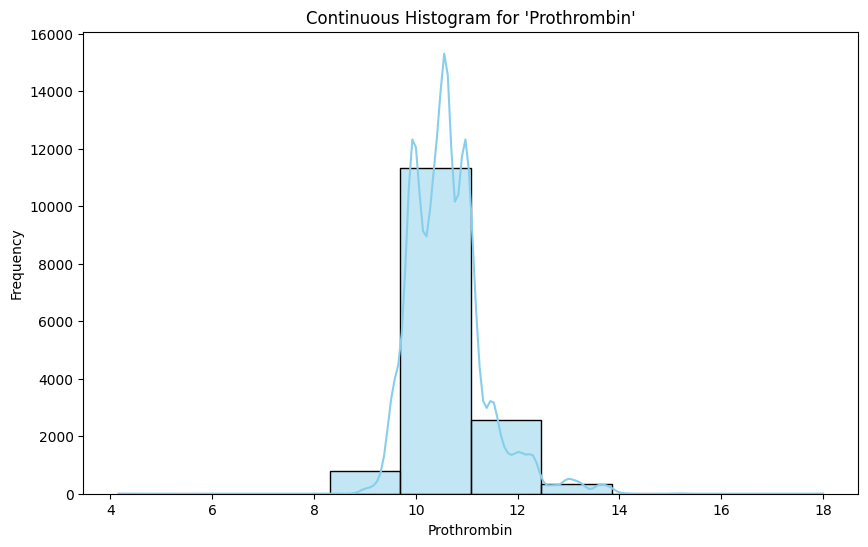

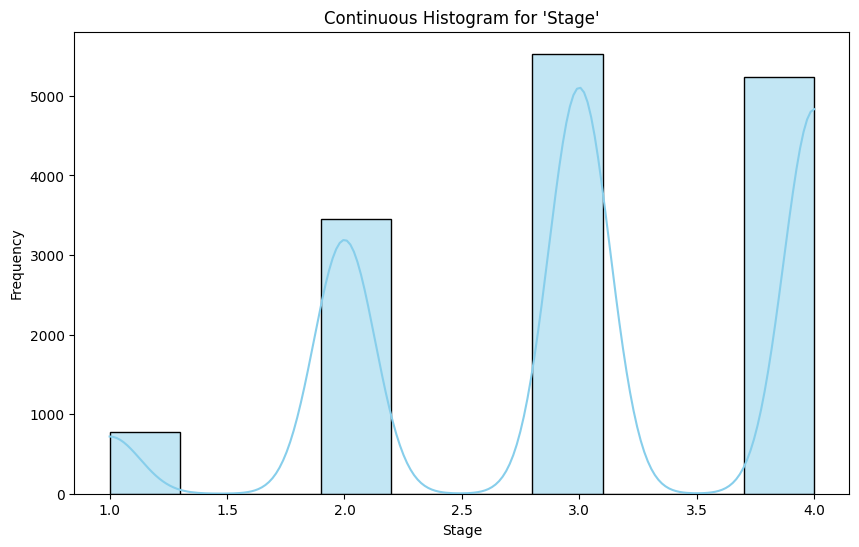

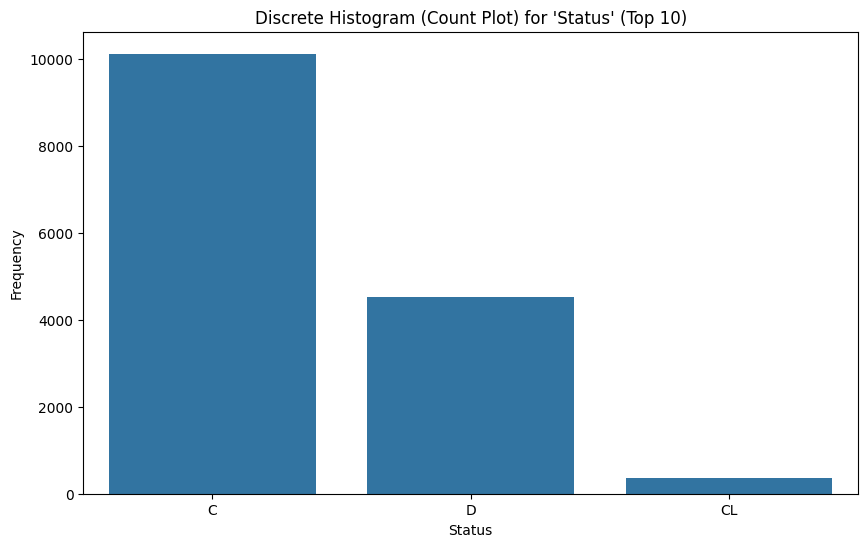

In [192]:
# Visualize the distribution of each feature (categorical and continuous)

for column in df_des.columns:
    plt.figure(figsize=(10, 6))

    if df[column].dtype == 'object':
        top_10 = df[column].value_counts().nlargest(10).index
        sns.countplot(x=df[column], order=top_10)
        plt.title(f"Discrete Histogram (Count Plot) for '{column}' (Top 10)")
    else:
        sns.histplot(df[column], kde=True, color='skyblue', bins=10)
        plt.title(f"Continuous Histogram for '{column}'")

    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

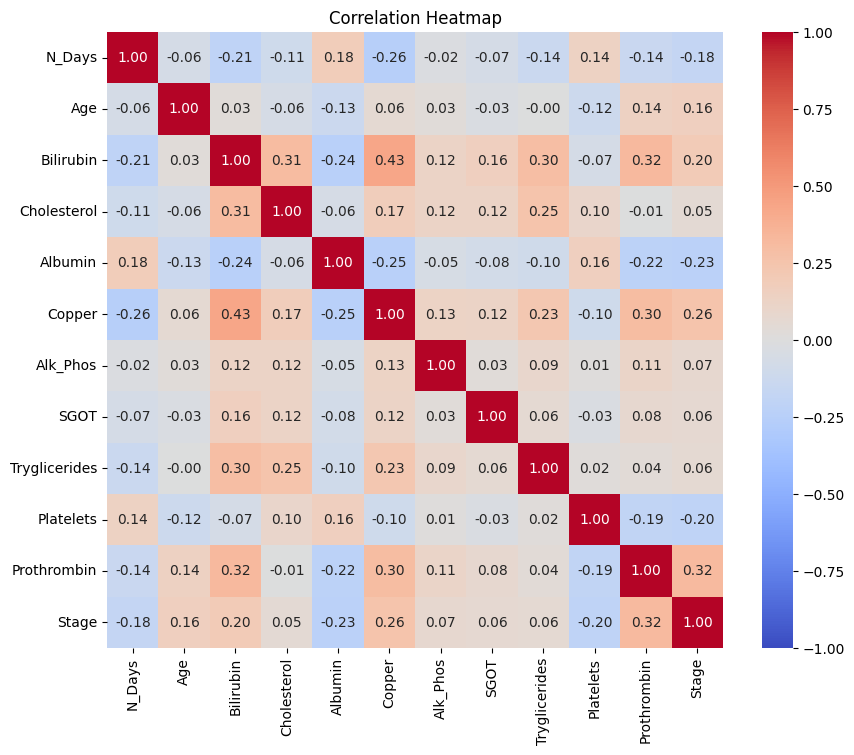

In [193]:
# Generate correlation matrix
correlation_matrix = df_des.select_dtypes(include="number").corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", square=True, vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()


In [194]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim)) if min_dim != 0 else 0

def correlation_ratio(categories, values):
    categories = pd.Categorical(categories)
    values = np.array(values)

    ssw = sum(sum((values[categories == category] - np.mean(values[categories == category]))**2)
              for category in categories.categories)
    sst = sum((values - np.mean(values))**2)

    return np.sqrt(1 - ssw/sst) if sst != 0 else 0

def visualize_correlations(df, target_col, figsize=(15, 10), categorical_features=None):
    df_copy = df.copy()

    if categorical_features is None:
        categorical_features = []

    for feature in df_copy.columns:
        if not pd.api.types.is_numeric_dtype(df_copy[feature]) and feature not in categorical_features:
            categorical_features.append(feature)

    correlations = {}
    features = [col for col in df_copy.columns if col != target_col]

    target_is_categorical = not pd.api.types.is_numeric_dtype(df_copy[target_col]) or target_col in categorical_features

    for feature in features:
        feature_is_categorical = not pd.api.types.is_numeric_dtype(df_copy[feature]) or feature in categorical_features

        valid_mask = ~(df_copy[feature].isna() | df_copy[target_col].isna())

        if valid_mask.any():
            if target_is_categorical:
                if feature_is_categorical:
                    corr = cramers_v(df_copy[feature], df_copy[target_col])
                else:
                    corr = correlation_ratio(df_copy[target_col], df_copy[feature])
            else:
                if feature_is_categorical:
                    corr = correlation_ratio(df_copy[feature], df_copy[target_col])
                else:
                    corr, _ = pearsonr(df_copy[feature][valid_mask], df_copy[target_col][valid_mask])

            correlations[feature] = corr

    correlations = dict(sorted(correlations.items(),
                             key=lambda x: abs(x[1]),
                             reverse=True))

    plt.figure(figsize=figsize)

    colors = ['b' for _ in correlations.values()]
    plt.bar(range(len(correlations)),
           list(correlations.values()),
           color=colors,
           alpha=0.6)
    plt.xticks(range(len(correlations)),
               list(correlations.keys()),
               rotation=45,
               ha='right')

    if target_is_categorical:
        plt.title(f"Feature Associations with {target_col}\n(Correlation Ratio for Numerical, Cramer's V for Categorical)")
        plt.ylabel('Association Strength')
    else:
        plt.title(f"Absolute Correlation Strength with {target_col}")
        plt.ylabel('|Correlation Coefficient|')

    plt.tight_layout()

    print(f"\nAssociation values with {target_col}")
    print("-" * 40)
    for feature, corr in correlations.items():
        print(f"{feature}: {corr:.3f}")

    return correlations

print("Function succesfully loaded.")

Function succesfully loaded.



Association values with Status
----------------------------------------
Bilirubin: 0.416
Spiders: 0.372
Ascites: 0.327
Hepatomegaly: 0.314
N_Days: 0.243
Edema: 0.223
Age: 0.215
Cholesterol: nan
Albumin: 0.279
Sex: 0.112
Drug: 0.057
Copper: nan
Alk_Phos: nan
SGOT: nan
Tryglicerides: nan
Platelets: nan
Prothrombin: nan
Stage: 0.318


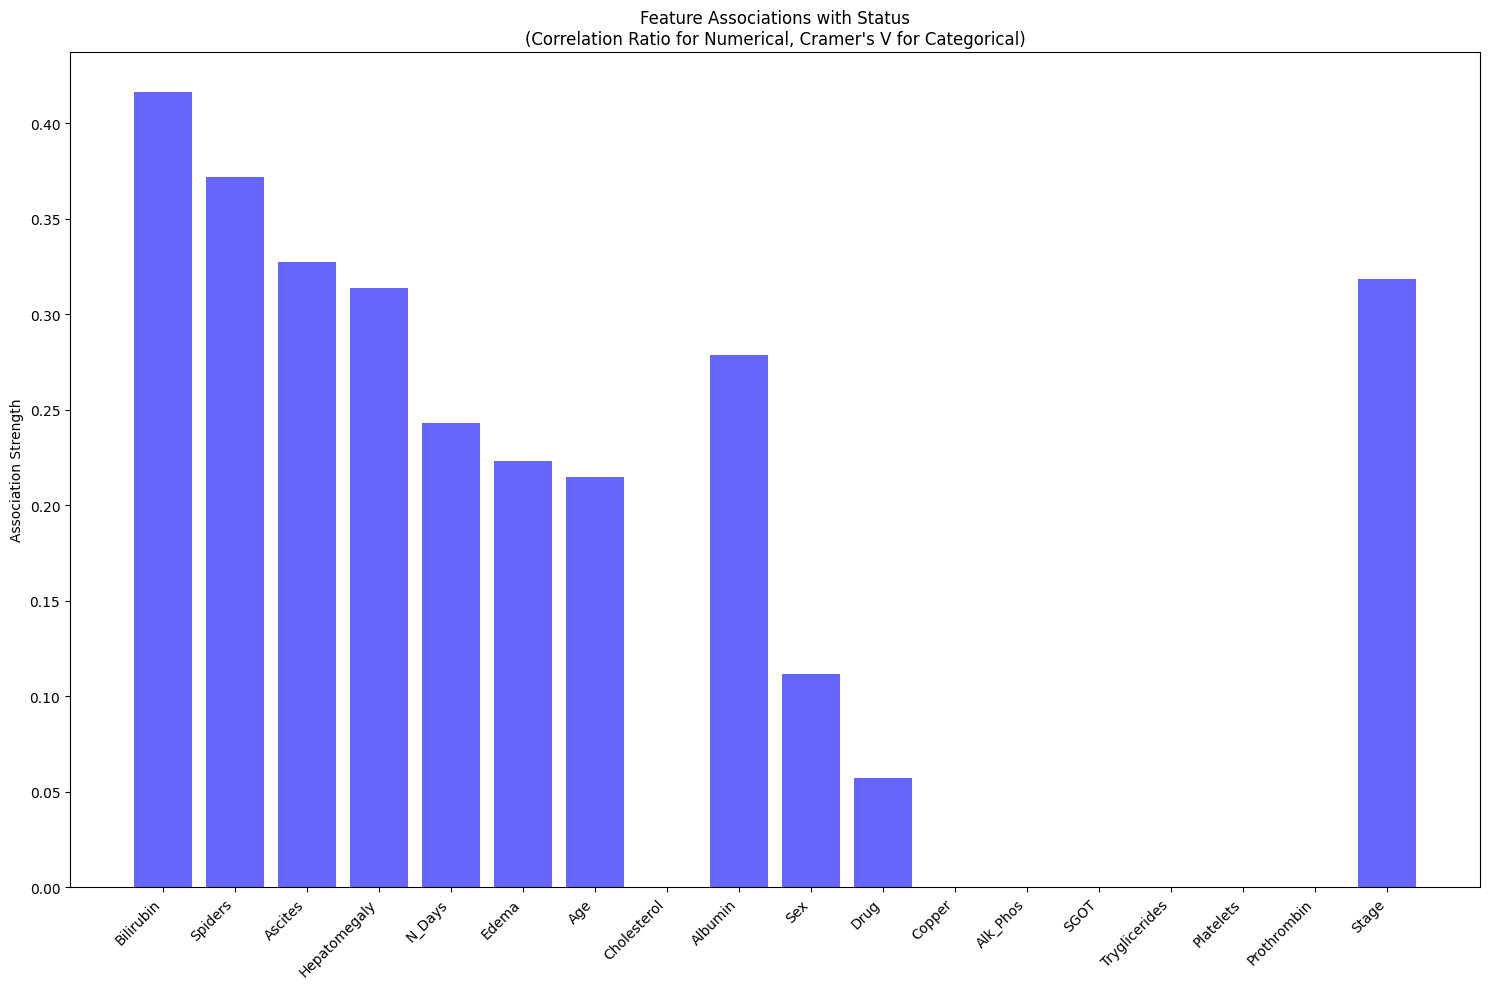

In [195]:
target_column = 'Status'
df_vis = df_des
correlations = visualize_correlations(df_vis, target_column, categorical_features=categorical_features)


# 2. Split Training Set and Validation Set

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. If you want to use k-fold cross-validation, split the data later and do the cleaning and preprocessing separately for each split.

Note: For training, you should use the data contained in the `train.csv` given by the TA. The `test.csv` data is only used for kaggle submission.

In [203]:
# Split training set and validation set here, store into variables train_set and val_set.
# Remember to also keep the original training set before splitting. This will come important later.
# train_set, val_set = ...

from sklearn.model_selection import train_test_split

df.reset_index()
train_set, val_set = train_test_split(df, test_size=0.2, random_state=42)

# X = df.drop(columns=['Status'],axis=1)
# y = df['Status']
# X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2)
# train_set = X_train.join(y_train)
# val_set = X_val.join(y_val)


print("Set is splitted...")
train_set

Set is splitted...


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
9839,9839,1967.0,D-penicillamine,14019.0,F,N,Y,N,N,2.1,315.0,3.69,75.0,1637.0,170.50,70.0,136.0,9.6,3.0,C
9680,9680,4190.0,Placebo,14060.0,F,N,N,N,N,0.9,232.0,3.50,24.0,423.0,49.60,126.0,213.0,10.1,2.0,C
7093,7093,2812.0,NaN,18302.0,F,NaN,NaN,NaN,N,0.7,NaN,3.48,NaN,NaN,NaN,NaN,273.0,10.6,3.0,C
11293,11293,3149.0,D-penicillamine,20459.0,F,N,N,N,N,0.9,298.0,3.65,25.0,685.0,71.30,85.0,311.0,9.7,3.0,C
820,820,460.0,D-penicillamine,23241.0,M,N,N,N,N,0.9,390.0,3.90,39.0,645.0,70.00,93.0,228.0,12.3,3.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,5191,2716.0,NaN,19358.0,F,NaN,NaN,NaN,N,0.6,NaN,3.58,NaN,NaN,NaN,NaN,330.0,9.9,3.0,C
13418,13418,625.0,NaN,23741.0,F,NaN,NaN,NaN,N,4.4,NaN,3.40,NaN,NaN,NaN,NaN,190.0,11.0,4.0,D
5390,5390,2534.0,NaN,21185.0,F,NaN,NaN,NaN,N,0.6,NaN,3.45,NaN,NaN,NaN,NaN,200.0,10.3,4.0,C
860,860,2456.0,D-penicillamine,17774.0,F,N,N,N,N,1.4,219.0,3.60,74.0,1009.0,141.05,108.0,271.0,10.1,3.0,C


# 3. Data Cleaning and Preprocessing

This step is the first thing to be done once a Data Scientist have grasped a general knowledge of the data. Raw data is **seldom ready for training**, therefore steps need to be taken to clean and format the data for the Machine Learning model to interpret.

By performing data cleaning and preprocessing, you ensure that your dataset is ready for model training, leading to more accurate and reliable machine learning results. These steps are essential for transforming raw data into a format that machine learning algorithms can effectively learn from and make predictions.

For each step that you will do, **please explain the reason why did you do that process. Write it in a markdown cell under the code cell you wrote.**

In [197]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline



In [198]:
class FeatureImputer(BaseEstimator, TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None):
        self.numerical_features = X.select_dtypes(include=['number']).columns.tolist()
        self.categorical_features = X.select_dtypes(include=['object']).columns.tolist()

        self.si_numerical = SimpleImputer().fit(X[self.numerical_features])
        self.si_categorical = SimpleImputer(strategy='most_frequent').fit(X[self.categorical_features])
        return self
    
    def transform(self, X: pd.DataFrame):
        X_copy = X.copy()  # Create a copy to avoid modifying the original DataFrame
        X_copy[self.numerical_features] = self.si_numerical.transform(X_copy[self.numerical_features])
        X_copy[self.categorical_features] = self.si_categorical.transform(X_copy[self.categorical_features])
        return X_copy

In [199]:
class FeatureScaler(BaseEstimator, TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None):
        self.numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
        self.sc = StandardScaler().fit(X[self.numerical_cols])
        return self
    def transform(self, X: pd.DataFrame):
        X[self.numerical_cols] = self.sc.transform(X[self.numerical_cols])
        return X

In [ ]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None):
        self.categorical_features = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique() >= 2]
        self.fe = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(X[self.categorical_features])
        return self
    
    def transform(self, X: pd.DataFrame):
        X_copy = X.copy()
        # One-hot encode categorical columns
        encoded_cats = self.fe.transform(X_copy[self.categorical_features])

        
        # Create a DataFrame with encoded categories
        encoded_df = pd.DataFrame(
            encoded_cats, 
            columns=self.fe.get_feature_names_out(self.categorical_features),
            index=X_copy.index
        )
        
        # Drop original categorical columns and concatenate encoded columns
        X_copy = X_copy.drop(columns=self.categorical_features)
        return pd.concat([X_copy, encoded_df], axis=1)

# 3. Compile Preprocessing Pipeline

All of the preprocessing classes or functions defined earlier will be compiled in this step.

If you use sklearn to create preprocessing classes, you can list your preprocessing classes in the Pipeline object sequentially, and then fit and transform your data.

In [241]:
# from sklearn.pipeline import Pipeline

# # Note: You can add or delete preprocessing components from this pipeline

pipe = Pipeline([("imputer", FeatureImputer()),
                #  ("featurecreator", FeatureCreator()),
                 ("scaler", FeatureScaler()),
                 ("encoder", FeatureEncoder())
                 ])

train_set_clean = train_set.drop(columns=['Status','id'])
val_set_clean = val_set.drop(columns=['Status','id'])
df_test_clean = df_test.drop(columns=['id'])

pipe.fit(train_set_clean)
train_set_transform = pipe.transform(train_set_clean)
val_set_transform = pipe.transform(val_set_clean)
test_data_transform = pipe.transform(df_test_clean)

# train_set_clean.head()
train_set_transform.head()

['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']
['Drug_D-penicillamine' 'Drug_Placebo' 'Sex_F' 'Sex_M' 'Ascites_N'
 'Ascites_Y' 'Hepatomegaly_158.0' 'Hepatomegaly_N' 'Hepatomegaly_Y'
 'Spiders_N' 'Spiders_Y' 'Edema_N' 'Edema_S' 'Edema_Y']
['Drug_D-penicillamine' 'Drug_Placebo' 'Sex_F' 'Sex_M' 'Ascites_N'
 'Ascites_Y' 'Hepatomegaly_158.0' 'Hepatomegaly_N' 'Hepatomegaly_Y'
 'Spiders_N' 'Spiders_Y' 'Edema_N' 'Edema_S' 'Edema_Y']
['Drug_D-penicillamine' 'Drug_Placebo' 'Sex_F' 'Sex_M' 'Ascites_N'
 'Ascites_Y' 'Hepatomegaly_158.0' 'Hepatomegaly_N' 'Hepatomegaly_Y'
 'Spiders_N' 'Spiders_Y' 'Edema_N' 'Edema_S' 'Edema_Y']


,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_158.0,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
9839,0.001747,-1.429877,0.083350,-6.017460e-02,0.451216,-0.020791,-2.423310e-02,4.856234e-01,-1.232549e+00,-1.296253,-1.410323,-0.026508,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
9680,1.614965,-1.418739,-0.349776,-8.494793e-01,-0.059584,-0.920724,-8.943109e-01,-4.716036e-01,4.584479e-01,-0.452755,-0.722726,-1.158518,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
7093,0.614958,-0.266380,-0.421963,-5.405636e-16,-0.113353,0.000000,1.629595e-16,1.125146e-16,4.291163e-16,0.204516,-0.035129,-0.026508,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
11293,0.859517,0.319579,-0.349776,-2.218394e-01,0.343679,-0.903078,-7.065346e-01,-2.997936e-01,-7.796034e-01,0.620788,-1.272804,-0.026508,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
820,-1.091874,1.075323,-0.349776,6.530526e-01,1.015786,-0.656038,-7.352027e-01,-3.100864e-01,-5.380324e-01,-0.288437,2.302700,-0.026508,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [257]:
def predict_and_create_dataframe(clf, X_val, df_test):
    """
    Create a DataFrame of predictions with probabilities and IDs as the first column.
    
    Parameters:
    -----------
    y_pred_proba : array-like
        Predicted probabilities
    classes : array-like
        Class labels
    ids : array-like
        Corresponding IDs
    
    Returns:
    --------
    DataFrame
        Predictions with probabilities, indexed by ID
    """
    # Create the DataFrame
    y_pred_proba = clf.predict_proba(X_val)
    y_pred_df = pd.DataFrame(y_pred_proba, columns=clf.classes_)
    y_pred_df['id'] = df_test['id'].values
    
    # Reorder the columns to make 'id' the first column
    cols = ['id'] + [col for col in y_pred_df.columns if col != 'id']
    y_pred_df = y_pred_df[cols]
    
    # Set the index to 'id'
    y_pred_df.set_index('id', inplace=True)

    # Export the DataFrame to CSV
    export_path = "predictions_results.csv"
    y_pred_df.to_csv(export_path)
    print(f"Predictions exported to {export_path}")
    
    return y_pred_df

In [242]:
X_trainset = train_set_transform
y_trainset = train_set['Status']
X_valset = val_set_transform
y_valset = val_set['Status']

or create your own here

# 4. Modeling and Validation

Modelling is the process of building your own machine learning models to solve specific problems, or in this assignment context, predicting the probability for each class in the `Status` feature (`Status_C`, `Status_CL`, `Status_D`). Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

## KNN

In [265]:
# Type your code here
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss

clf = KNeighborsClassifier()
clf.fit(X_trainset, y_trainset)

# Predict probabilities
y_pred_proba = clf.predict_proba(X_valset)
log_loss_score = log_loss(y_valset, y_pred_proba)

print(f"Log Loss: {log_loss_score}")


Log Loss: 2.2032132051375366


## Naive Bayes

In [266]:
from sklearn.naive_bayes import GaussianNB


# Train the classifier
clf = GaussianNB()
clf.fit(X_trainset, y_trainset)

# Predict probabilities
y_pred_proba = clf.predict_proba(X_valset)
log_loss_score = log_loss(y_valset, y_pred_proba)

print(f"Log Loss: {log_loss_score}")

# Create a DataFrame with probabilities and IDs
# Assuming binary classification (if multi-class, adjust column names accordingly)
# y_pred_df = predict_and_create_dataframe(clf, test_data_transform, df_test)

# y_pred_df

Log Loss: 4.58474606040809


## ID3

In [264]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=1)
clf.fit(X_trainset, y_trainset)

# Predict probabilities
y_pred_proba = clf.predict_proba(X_valset)
log_loss_score = log_loss(y_valset, y_pred_proba)

print(f"Log Loss: {log_loss_score}")

Log Loss: 7.9055746433463625


## SVM

In [271]:
# Type your code here
from sklearn.svm import SVC

clf = SVC(probability=True)
clf.fit(X_trainset, y_trainset)

# Predict probabilities
y_pred_proba = clf.predict_proba(X_valset)
log_loss_score = log_loss(y_valset, y_pred_proba)

print(f"Log Loss: {log_loss_score}")

y_pred_df = predict_and_create_dataframe(clf, test_data_transform, df_test)

y_pred_df

Log Loss: 0.4335631758174157
Predictions exported to predictions_results.csv


,C,CL,D
id,,,
15000,0.051402,0.008011,0.940587
15001,0.802896,0.017018,0.180086
15002,0.913798,0.016677,0.069525
15003,0.915799,0.020339,0.063861
15004,0.901544,0.015453,0.083003
...,...,...,...
24995,0.886061,0.015586,0.098353
24996,0.589106,0.030343,0.380551
24997,0.110985,0.011158,0.877857


## Logistic Regression

In [270]:
# Type your code here
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_trainset, y_trainset)

# Predict probabilities
y_pred_proba = clf.predict_proba(X_valset)
log_loss_score = log_loss(y_valset, y_pred_proba)

print(f"Log Loss: {log_loss_score}")

Log Loss: 0.4409752011097829


## Notes for improvements

- **Visualize the model evaluation result**

This will help you to understand the details more clearly about your model's performance. From the visualization, you can see clearly if your model is leaning towards a class than the others. (Hint: confusion matrix, ROC-AUC curve, etc.)

- **Explore the hyperparameters of your models**

Each models have their own hyperparameters. And each of the hyperparameter have different effects on the model behaviour. You can optimize the model performance by finding the good set of hyperparameters through a process called **hyperparameter tuning**. (Hint: Grid search, random search, bayesian optimization)

- **Cross-validation**

Cross-validation is a critical technique in machine learning and data science for evaluating and validating the performance of predictive models. It provides a more **robust** and **reliable** evaluation method compared to a hold-out (single train-test set) validation. Though, it requires more time and computing power because of how cross-validation works. (Hint: k-fold cross-validation, stratified k-fold cross-validation, etc.)

- **Ensemble methods**

Ensemble methods are powerful machine learning techniques that combine the predictions of multiple models (often referred to as base learners or weak learners) to create a stronger, more accurate predictive model. The idea behind ensemble methods is that by aggregating the opinions of multiple models, you can reduce the impact of individual model errors and improve overall prediction performance. (Hint: bagging, boosting, stacking, voting)

- **Model interpretation**

Model interpretation is the process of understanding and explaining the inner workings of a machine learning model, particularly its decision-making process. Interpretation helps data scientists, stakeholders, and end-users gain insights into why a model makes certain predictions or classifications. Model interpretation is crucial for building trust in machine learning systems, identifying biases, and extracting actionable information from models. (Hint: Feature importance, PDP, SHAP Values, etc)

- **Explore other models**

There are a lot of ML models that you can use in this usecase. Try to explore and use them to solve this problem.

## Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set
5. Make sure the submission contains the `id`, `Status_C`, `Status_CL`, `Status_D` column.

In [ ]:
# Type your code here

SyntaxError: invalid syntax (2266301613.py, line 1)

# 6. Error Analysis

Based on all the process you have done until the modeling and evaluation step, write an analysis to support each steps you have taken to solve this problem. Write the analysis using the markdown block. Some questions that may help you in writing the analysis:

- Does my model perform better in predicting one class than the other? If so, why is that?
- To each models I have tried, which performs the best and what could be the reason?
- Is it better for me to impute or drop the missing data? Why?
- Does feature scaling help improve my model performance?
- etc...

`Provide your analysis here`